# 테스트 방법 정리

  - 6개종별 : 이미지파일 400장으로 추가수집
  - 이미지 전처리: 크기조정(224,224) 
  - 폴더생성 : New_Data_Set1/Train_Test_Valid
  - 대상폴더 : Train/vaild/test 에 각 1680/480/240장으로 자료복사 (중복없음)
  - 훈련조건 : 사전 학습된 ResNet50을 이용
               epochs= 100
               monitor= 'val_loss'  # 검증 손실을 기준으로 저장
               optimizer= 'adam'    # Adam 최적화 알고리즘
               loss= 'sparse_categorical_crossentropy'
               metrics= 'accuracy' # 모델의 정확도를 평가 지표로 사용
               ResNet_model_1119_2.h5  #저장모델명
               ----------------
               Dropout 0.3, 05.를 추가함
               
  - 훈련결과 : * 성능평가시 
                  - 15/15 - 1s - loss: 0.3024 - accuracy: 0.9292
                    Test Loss: 0.3023581802845001
                    Test Accuracy: 0.9291666746139526                
               * 저장된 모델로 성능 재평가시  
                  - 15/15 - 2s - loss: 0.3024 - accuracy: 0.9292
                    Test Loss: 0.3023581802845001
                    Test Accuracy: 0.9291666746139526
                  
  - 회고 : 이미지의 갯수를 학습할 폴더에 추가하고, 
           에포크:100회로 학습횟수가 늘어나니 정확도가 올라간것을 확인했다.
           기존과 다르게 한게 있다면 폴더에 직접 해당 수치 만큼의 자료를 각각 넣어준 부분이 기존과
           다른부분이다.
           이미지 데이타 전처리시 정확한 이미지와, 잘못 분류된 자료없이 갯수가 많은 자료로 
           에포크 조정, dropout 추가 등으로 학습을 진행시 성능이 개선되는게 확인되었다.

# 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore') # 경고 메시지 뜨지 않게

# 이미지 불러오기 및 전처리

In [2]:
# 데이터셋 읽어오기

# 훈련셋 불러오기
image_data = 'New_Data_Set1/Train_Test_Valid/Train'
pd.DataFrame(os.listdir(image_data), columns=['Files_Name'])

,Files_Name
0,moon_jellyfish
1,blue_jellyfish
2,compass_jellyfish
3,lions_mane_jellyfish
4,barrel_jellyfish
5,mauve_stinger_jellyfish


In [3]:
# 검증셋 불러오기
image_valid_data = 'New_Data_Set1/Train_Test_Valid/valid'
pd.DataFrame(os.listdir(image_valid_data), columns=['Files_Name'])

,Files_Name
0,moon_jellyfish
1,blue_jellyfish
2,compass_jellyfish
3,lions_mane_jellyfish
4,barrel_jellyfish
5,mauve_stinger_jellyfish


In [4]:
# 데이터프레임을 생성하는 함수 정의
def create_dataframe(image_folder):
    files = glob.glob(os.path.join(image_folder, '**', '*.*'), recursive=True)  # 모든 파일을 재귀적으로 검색
    np.random.shuffle(files)  # 파일을 섞음
    labels = [os.path.basename(os.path.dirname(f)) for f in files]  # 폴더 이름에서 라벨 추출
    return pd.DataFrame({'Image': files, 'Label': labels})

# 훈련 및 검증 데이터프레임 생성
dataframe_train = create_dataframe(image_data)
dataframe_valid = create_dataframe(image_valid_data)

# 데이터프레임의 첫 몇 행을 표시
dataframe_train.head(), dataframe_valid.head()

(                                               Image             Label
 0  New_Data_Set1/Train_Test_Valid/Train/barrel_je...  barrel_jellyfish
 1  New_Data_Set1/Train_Test_Valid/Train/moon_jell...    moon_jellyfish
 2  New_Data_Set1/Train_Test_Valid/Train/blue_jell...    blue_jellyfish
 3  New_Data_Set1/Train_Test_Valid/Train/moon_jell...    moon_jellyfish
 4  New_Data_Set1/Train_Test_Valid/Train/barrel_je...  barrel_jellyfish,
                                                Image              Label
 0  New_Data_Set1/Train_Test_Valid/valid/blue_jell...     blue_jellyfish
 1  New_Data_Set1/Train_Test_Valid/valid/compass_j...  compass_jellyfish
 2  New_Data_Set1/Train_Test_Valid/valid/compass_j...  compass_jellyfish
 3  New_Data_Set1/Train_Test_Valid/valid/moon_jell...     moon_jellyfish
 4  New_Data_Set1/Train_Test_Valid/valid/barrel_je...   barrel_jellyfish)

Dataset                   Training  Validation
Label                                         
barrel_jellyfish         16.666667   16.666667
blue_jellyfish           16.666667   16.666667
compass_jellyfish        16.666667   16.666667
lions_mane_jellyfish     16.666667   16.666667
mauve_stinger_jellyfish  16.666667   16.666667
moon_jellyfish           16.666667   16.666667


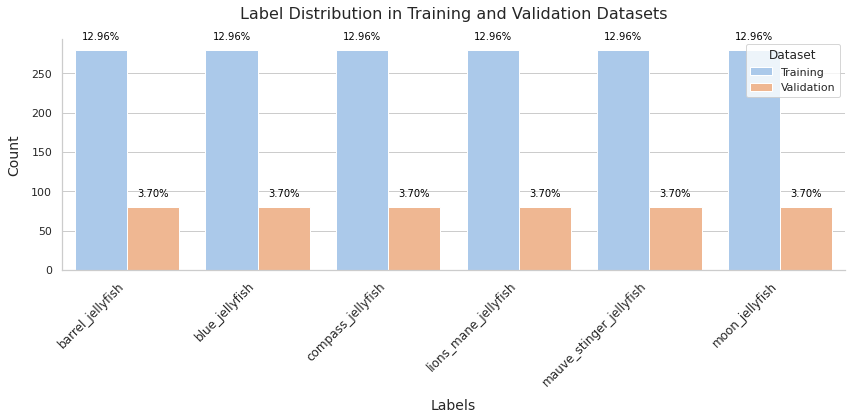

In [5]:
# 훈련 및 검증 데이터프레임에 데이터셋 구분 열 추가
dataframe_train['Dataset'] = 'Training'
dataframe_valid['Dataset'] = 'Validation'

# 두 데이터프레임을 결합
combined_df = pd.concat([dataframe_train, dataframe_valid], ignore_index=True)

# 더 나은 미관을 위해 테마 설정
sns.set_theme(style="whitegrid")

# 각 데이터셋의 라벨별 개수 및 비율 계산
count_data = combined_df.groupby(['Label', 'Dataset']).size().unstack(fill_value=0)
percentage_data = count_data.div(count_data.sum(axis=0), axis=1) * 100

# 비율 데이터 출력 (선택 사항)
print(percentage_data)

# 막대의 색상 팔레트 생성
palette = sns.color_palette("pastel", len(count_data))

# 훈련 및 검증 데이터셋의 라벨 분포를 나타내는 막대 그래프 생성
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x="Label", hue="Dataset", order=count_data.sum(axis=1).sort_values(ascending=False).index, palette="pastel")

# 각 막대에 비율 값 주석 추가
for p in ax.patches:
    height = p.get_height()  # 막대의 높이 가져오기
    percentage = f'{(height / len(combined_df)) * 100:.2f}%'  # 비율 계산
    ax.annotate(percentage,  # 주석으로 추가할 라벨
                (p.get_x() + p.get_width() / 2., height),  # 라벨의 위치
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

# x축 라벨을 더 잘 보이도록 회전하고 폰트 크기 설정
plt.xticks(rotation=45, ha='right', fontsize=12)

# 제목과 라벨 추가 (폰트 및 패딩 개선)
plt.title("Label Distribution in Training and Validation Datasets", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

# 상단과 오른쪽 테두리를 제거하여 깔끔한 모양으로 만듦
sns.despine()

# 그래프를 표시
plt.tight_layout()  # 겹침을 방지하기 위해 레이아웃 조정
plt.show()

전체 데이터 개수: 2400
훈련 세트 개수: 1680 (70.00%)
검증 세트 개수: 480 (20.00%)
테스트 세트 개수: 240 (10.00%)


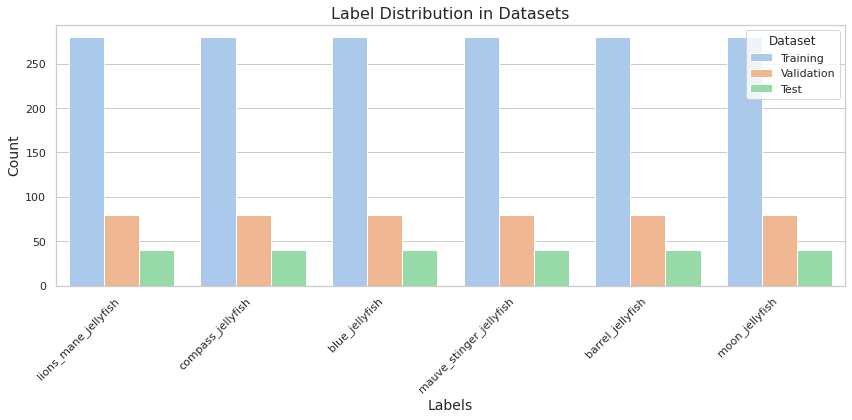

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


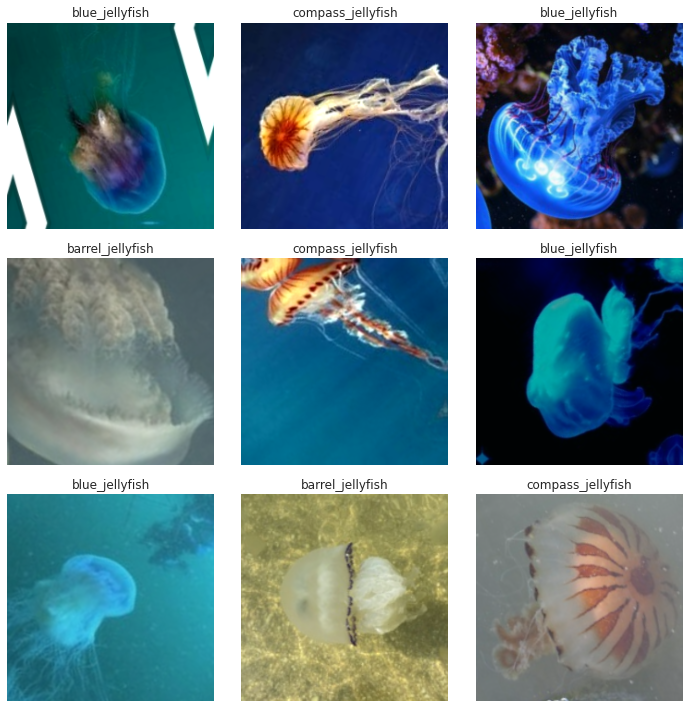

In [8]:
# 데이터 디렉토리 설정
train_dir = 'New_Data_Set1/Train_Test_Valid/Train'
valid_dir = 'New_Data_Set1/Train_Test_Valid/valid'
test_dir = 'New_Data_Set1/Train_Test_Valid/test'

# 모든 데이터를 합치기
def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    file_paths.append(os.path.join(class_dir, fname))
                    labels.append(class_name)
    return file_paths, labels

# 각 폴더에서 이미지와 라벨 불러오기
train_file_paths, train_labels = get_file_paths_and_labels(train_dir)
valid_file_paths, valid_labels = get_file_paths_and_labels(valid_dir)
test_file_paths, test_labels = get_file_paths_and_labels(test_dir)

# 모든 데이터를 합치기
all_file_paths = train_file_paths + valid_file_paths + test_file_paths
all_labels = train_labels + valid_labels + test_labels

# 데이터프레임 생성
data_df = pd.DataFrame({'file_path': all_file_paths, 'label': all_labels})

# 라벨 인코딩
class_names = sorted(data_df['label'].unique())
num_classes = len(class_names)
label_to_index = dict((name, index) for index, name in enumerate(class_names))
data_df['label_index'] = data_df['label'].map(label_to_index)

# 데이터를 원하는 비율로 훈련, 검증, 테스트 세트로 분할
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    data_df['file_path'], data_df['label_index'],
    test_size=0.1,  # 전체 데이터의 10%를 테스트 세트로 사용
    stratify=data_df['label_index'],
    random_state=123
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.2222,  # 남은 데이터의 22.22%를 검증 세트로 사용하여 전체의 20%가 되도록 설정
    stratify=train_val_labels,
    random_state=123
)

# 분할된 데이터의 비율 확인
total_count = len(data_df)
train_count = len(train_paths)
val_count = len(val_paths)
test_count = len(test_paths)

print(f"전체 데이터 개수: {total_count}")
print(f"훈련 세트 개수: {train_count} ({train_count/total_count*100:.2f}%)")
print(f"검증 세트 개수: {val_count} ({val_count/total_count*100:.2f}%)")
print(f"테스트 세트 개수: {test_count} ({test_count/total_count*100:.2f}%)")

# 라벨별 개수 시각화
def plot_label_distribution(labels, dataset_name):
    label_counts = pd.Series(labels).value_counts()
    label_counts.index = [class_names[i] for i in label_counts.index]
    df = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
    df['Dataset'] = dataset_name
    return df

train_df = plot_label_distribution(train_labels, 'Training')
val_df = plot_label_distribution(val_labels, 'Validation')
test_df = plot_label_distribution(test_labels, 'Test')

combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(data=combined_df, x='Label', y='Count', hue='Dataset', palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.title('Label Distribution in Datasets', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# 이미지 전처리 함수 정의
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # 정규화
    return image, label

# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# 훈련 데이터셋 생성
train_ds = tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_labels)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

# 검증 데이터셋 생성
val_ds = tf.data.Dataset.from_tensor_slices((list(val_paths), list(val_labels)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 테스트 데이터셋 생성
test_ds = tf.data.Dataset.from_tensor_slices((list(test_paths), list(test_labels)))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 배치 및 프리페치 설정
batch_size = 16

train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 데이터 증강 결과 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = images[i].numpy()
        label = class_names[labels[i]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.title(label)
        plt.axis("off")
plt.tight_layout()
plt.show()

# 모델 생성

In [9]:
# Pre-trained ResNet50 모델을 불러옵니다.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #최상위 분류 레이어를 제외하고, 기본적인 특성 추출 부분만 불러옵니다.
base_model.trainble = False           # 모델층의 동결

x = base_model.output
x = GlobalAveragePooling2D()(x)    # 경량화와 빠른 학습, 적은 파라미터로 처리

x = Dropout(0.3)(x)  # 첫 번째 Dropout 추가 (30% 뉴런 비활성화, 11/19 add)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)  # 두 번째 Dropout 추가 (50% 뉴런 비활성화, 11/19 add)

outputs = Dense(6, activation='softmax')(x) # 해파리를 6개의 클래스로 분류
model = Model(base_model.input, outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

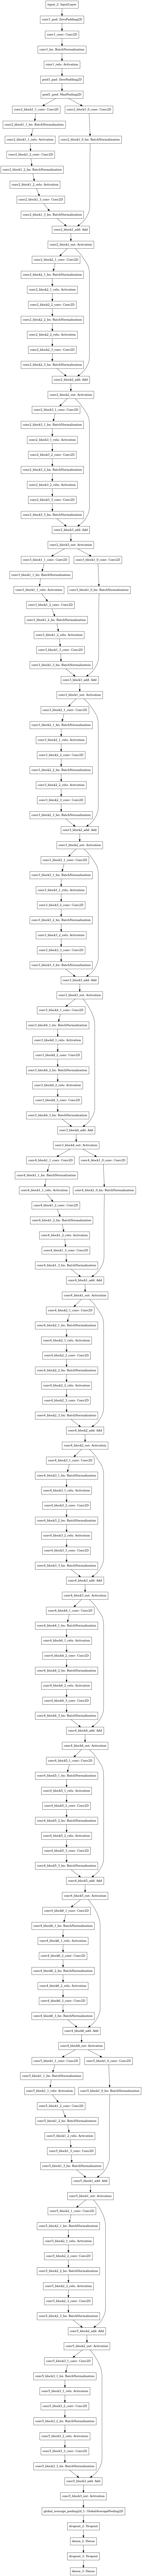

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# 모델 컴파일

In [11]:
model.compile(
    optimizer='adam',   # Adam 최적화 알고리즘 (일반적으로 잘 동작)
    loss='sparse_categorical_crossentropy',  # 타겟의 출력이 원-핫 인코딩된 형태가 아니라 정수형 라벨로 되어 있음. 다중 클래스 분류를 위한 손실 함수
    metrics=['accuracy']  # 모델의 정확도를 평가 지표로 사용
)

# 모델 훈련

In [12]:
callbacks = [
   #keras.callbacks.EarlyStopping(
   # monitor='val_loss',  # 검증 손실을 모니터링
   # patience=10,          # 검증 손실이 10번 에폭 동안 개선되지 않으면 훈련 중단
   # verbose=1,           # 중단 메시지 출력
   # restore_best_weights=True),  # 훈련 중단 시 가장 좋은 모델의 가중치를 복원
    
    keras.callbacks.ModelCheckpoint(
    'ResNet_model_1119_2.h5',  # 모델 저장 경로
    monitor='val_loss',    # 검증 손실을 기준으로 저장
    save_best_only=True,  # 가장 좋은 모델만 저장
    verbose=1)             # 저장 시 메시지 출력
]

history = model.fit(
    train_ds,  # 훈련 데이터
    epochs=100,
    validation_data=val_ds,  # 검증 데이터
    callbacks=callbacks)

# 모델 저장 (훈련 후 수동으로 저장)
model.save('ResNet_model_1119_2.h5')  # 모델 전체 저장

Epoch 1/100
105/105 [==============================] - 34s 193ms/step - loss: 2.1053 - accuracy: 0.3935 - val_loss: 1.7927 - val_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 1.79271, saving model to ResNet_model_1119_2.h5
Epoch 2/100
105/105 [==============================] - 25s 188ms/step - loss: 1.5709 - accuracy: 0.4137 - val_loss: 1.7956 - val_accuracy: 0.1667

Epoch 00002: val_loss did not improve from 1.79271
Epoch 3/100
105/105 [==============================] - 25s 191ms/step - loss: 1.2739 - accuracy: 0.5494 - val_loss: 1.8024 - val_accuracy: 0.1667

Epoch 00003: val_loss did not improve from 1.79271
Epoch 4/100
105/105 [==============================] - 25s 196ms/step - loss: 1.1250 - accuracy: 0.5982 - val_loss: 1.7993 - val_accuracy: 0.1583

Epoch 00004: val_loss did not improve from 1.79271
Epoch 5/100
105/105 [==============================] - 26s 199ms/step - loss: 0.9820 - accuracy: 0.6554 - val_loss: 2.8601 - val_accuracy: 0.1729

Epoch 00005: val_loss

105/105 [==============================] - 26s 198ms/step - loss: 0.3495 - accuracy: 0.8792 - val_loss: 1.4257 - val_accuracy: 0.6625

Epoch 00040: val_loss did not improve from 0.45054
Epoch 41/100
105/105 [==============================] - 25s 197ms/step - loss: 0.3398 - accuracy: 0.8875 - val_loss: 1.0044 - val_accuracy: 0.6583

Epoch 00041: val_loss did not improve from 0.45054
Epoch 42/100
105/105 [==============================] - 26s 197ms/step - loss: 0.3499 - accuracy: 0.8762 - val_loss: 0.6226 - val_accuracy: 0.8375

Epoch 00042: val_loss did not improve from 0.45054
Epoch 43/100
105/105 [==============================] - 25s 197ms/step - loss: 0.2981 - accuracy: 0.8952 - val_loss: 0.7350 - val_accuracy: 0.7812

Epoch 00043: val_loss did not improve from 0.45054
Epoch 44/100
105/105 [==============================] - 25s 196ms/step - loss: 0.3395 - accuracy: 0.8827 - val_loss: 0.6547 - val_accuracy: 0.8000

Epoch 00044: val_loss did not improve from 0.45054
Epoch 45/100
105/1

105/105 [==============================] - 26s 198ms/step - loss: 0.1683 - accuracy: 0.9399 - val_loss: 0.5020 - val_accuracy: 0.8896

Epoch 00081: val_loss did not improve from 0.43729
Epoch 82/100
105/105 [==============================] - 25s 196ms/step - loss: 0.1749 - accuracy: 0.9423 - val_loss: 0.7736 - val_accuracy: 0.7750

Epoch 00082: val_loss did not improve from 0.43729
Epoch 83/100
105/105 [==============================] - 26s 197ms/step - loss: 0.2429 - accuracy: 0.9262 - val_loss: 1.4596 - val_accuracy: 0.6646

Epoch 00083: val_loss did not improve from 0.43729
Epoch 84/100
105/105 [==============================] - 25s 197ms/step - loss: 0.1822 - accuracy: 0.9357 - val_loss: 1.2585 - val_accuracy: 0.6917

Epoch 00084: val_loss did not improve from 0.43729
Epoch 85/100
105/105 [==============================] - 25s 197ms/step - loss: 0.2135 - accuracy: 0.9351 - val_loss: 1.5585 - val_accuracy: 0.6646

Epoch 00085: val_loss did not improve from 0.43729
Epoch 86/100
105/1

# 학습결과

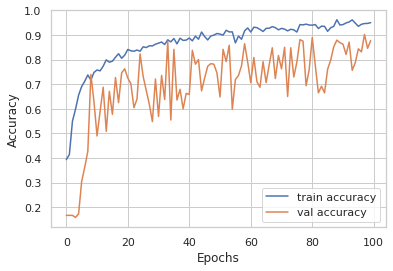

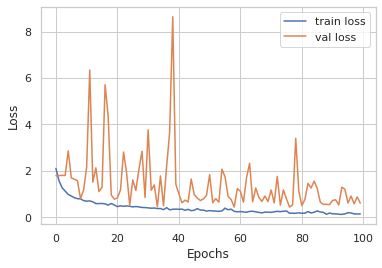

In [13]:
# 훈련 정확도와 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 훈련 손실과 검증 손실 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 - 1s - loss: 0.3024 - accuracy: 0.9292
Test Loss: 0.3023581802845001
Test Accuracy: 0.9291666746139526


In [15]:
model1 = tf.keras.models.load_model('ResNet_model_1119_2.h5')

test_loss, test_accuracy = model1.evaluate(test_ds, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 - 2s - loss: 0.3024 - accuracy: 0.9292
Test Loss: 0.3023581802845001
Test Accuracy: 0.9291666746139526
